In [1]:
!pip install kaggle



In [2]:
from google.colab import files
files.upload()  # Select kaggle.json from your local system


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sumanthsraj","key":"c1ececa92476050248e91cfa6d1e229e"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d jangedoo/utkface-new


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:10<00:00, 41.4MB/s]
100% 331M/331M [00:10<00:00, 34.0MB/s]


In [5]:
!unzip utkface-new.zip -d /content/utkface


Streaming output truncated to the last 5000 lines.
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  in

In [29]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Load Data
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])

# Shuffle Data
np.random.seed(10)
np.random.shuffle(filenames)

# Extract Age, Gender, and Race Labels
age_labels, gender_labels, race_labels, image_path = [], [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

# Create DataFrame
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, age_labels, gender_labels, race_labels
df = df[df['race'].isin(['0', '1', '2', '3', '4'])]

# Map Gender and Race
gender_dict = {0: "Male", 1: "Female"}
race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

# Splitting Data
train, test = train_test_split(df, train_size=0.8, random_state=42)

# Data Generator for Efficient Loading and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Update in the data generator to use 224x224
def custom_generator(dataframe, directory, batch_size, subset=None):
    generator = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    generator = generator.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col="image",
        y_col=None,
        target_size=(224, 224),  # Set to 224x224
        batch_size=batch_size,
        class_mode=None,
        shuffle=True,
        subset=subset
    )

    while True:
        # Get the batch of images
        batch_images = next(generator)

        # Get the indices for the current batch
        batch_indices = generator.index_array[:batch_size]  # Limit to batch_size

        # Select the labels for only the current batch using the batch indices
        batch_labels = dataframe.iloc[batch_indices]

        # Extract gender, age, and race labels
        gender = batch_labels['gender'].values
        age = batch_labels['age'].values
        race = to_categorical(batch_labels['race'].values, num_classes=5)

        # Ensure labels have consistent shapes
        gender = np.expand_dims(gender, axis=1)
        age = np.expand_dims(age, axis=1)

        # Yield only complete batches
        if len(batch_images) == batch_size:
            yield batch_images, {"gender_output": gender, "age_output": age, "race_output": race}

# Set batch size
batch_size = 32

# Train and Validation Generators
train_generator = custom_generator(train, str(path), batch_size=batch_size, subset="training")
validation_generator = custom_generator(train, str(path), batch_size=batch_size, subset="validation")
test_generator = custom_generator(test, str(path), batch_size=batch_size)

# Model Architecture - Using VGG16 with 224x224 input size
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in VGG16
for layer in conv_base.layers:
    layer.trainable = False

inputs = Input((224, 224, 3))  # Use 224x224 input size
X = conv_base(inputs)
X = Flatten()(X)

from tensorflow.keras.regularizers import l2

# Shared representation dense layer (256 nodes)
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)  # Change Dropout to 0.4

# Task-specific layers (gender, age, race)
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

from tensorflow.keras.optimizers import Adam

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss={
                  'gender_output': 'binary_crossentropy',
                  'age_output': 'mean_squared_error',
                  'race_output': 'categorical_crossentropy'
              },
              metrics={
                  'gender_output': 'accuracy',
                  'age_output': 'mean_absolute_error',
                  'race_output': 'accuracy'
              })

# Training the Model with Data Generators
checkpoint = ModelCheckpoint('best_model_by_race_output.keras', monitor='val_race_output_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(test) // batch_size,
    callbacks=[checkpoint, early_stopping]
)


Num GPUs Available:  1
23708
['3_0_0_20170110225025587.jpg.chip.jpg', '22_1_3_20170104231706746.jpg.chip.jpg', '1_1_2_20161219195732971.jpg.chip.jpg']
Found 17068 validated image filenames.
Epoch 1/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - age_output_mean_absolute_error: 19.2978 - gender_output_accuracy: 0.5311 - loss: 688.8802 - race_output_accuracy: 0.4444Found 1896 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_race_output_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


592/592 ━━━━━━━━━━━━━━━━━━━━ 120s 170ms/step - age_output_mean_absolute_error: 19.2923 - gender_output_accuracy: 0.5311 - loss: 688.5435 - race_output_accuracy: 0.4445 - val_age_output_mean_absolute_error: 13.6615 - val_gender_output_accuracy: 0.5359 - val_loss: 376.4407 - val_race_output_accuracy: 0.3564
Epoch 2/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 98s 166ms/step - age_output_mean_absolute_error: 10.5370 - gender_output_accuracy: 0.5504 - loss: 197.4461 - race_output_accuracy: 0.5322 - val_age_output_mean_absolute_error: 13.8944 - val_gender_output_accuracy: 0.5131 - val_loss: 344.0119 - val_race_output_accuracy: 0.4060
Epoch 3/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 98s 165ms/step - age_output_mean_absolute_error: 13.8574 - gender_output_accuracy: 0.5567 - loss: 317.4468 - race_output_accuracy: 0.5922 - val_age_output_mean_absolute_error: 15.2048 - val_gender_output_accuracy: 0.5427 - val_loss: 481.4621 - val_race_output_accuracy: 0.4196
Epoch 4/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 98s 166ms/step - ag

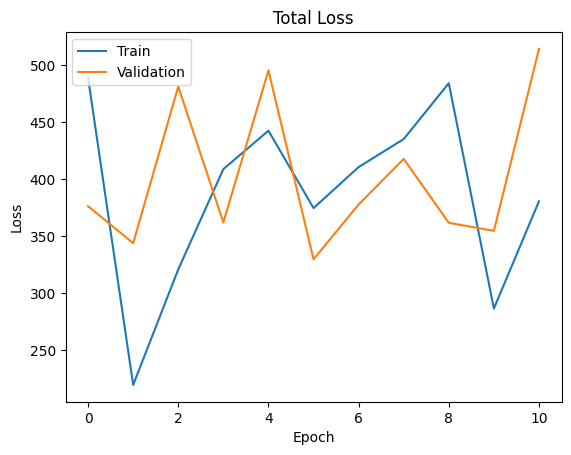

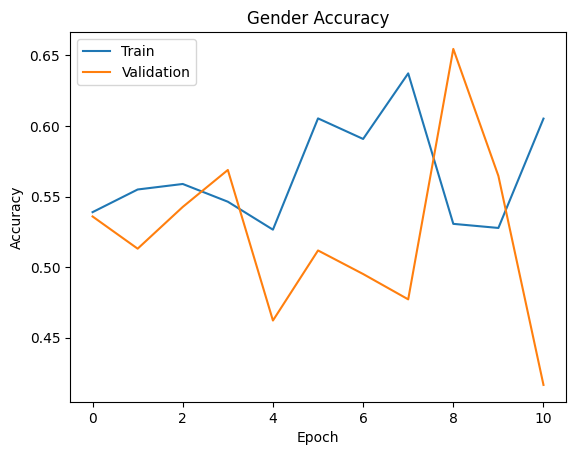

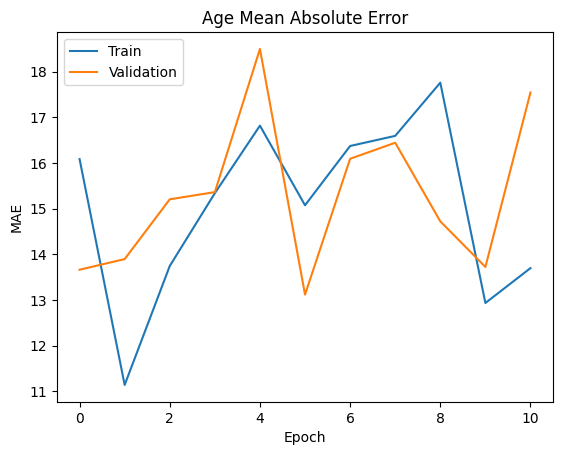

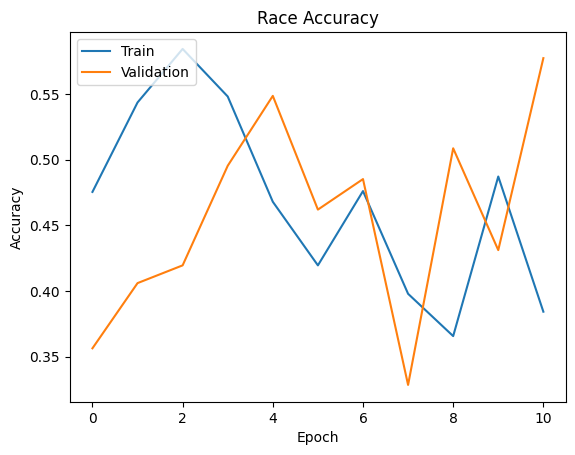

In [30]:
# Visualizing Losses
# Plot Combined Loss (total loss across all outputs)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Gender Accuracy
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Age Mean Absolute Error
plt.plot(history.history['age_output_mean_absolute_error'])
plt.plot(history.history['val_age_output_mean_absolute_error'])
plt.title('Age Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Race Accuracy
plt.plot(history.history['race_output_accuracy'])
plt.plot(history.history['val_race_output_accuracy'])
plt.title('Race Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



